# Japan Deflation Analysis

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# visualization
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

sns.set(color_codes=True)

In [2]:
def transform_dataset(data):
    data = data.set_index('Unnamed: 0')
    data.index.rename('', inplace=True)
    return data

In [3]:
# import relevant dataset
full_data = pd.read_csv('data/full_data.csv')
economic_index = pd.read_csv('data/ei_combined.csv')
cpi_index = pd.read_csv('data/cpi_index.csv')
gdp_production_index = pd.read_csv('data/gdp_production_index.csv')
health_index = pd.read_csv('data/health_index.csv')
population_index = pd.read_csv('data/population_index.csv')
ppp_index = pd.read_csv('data/ppp_index.csv')
productivity_ulc_index = pd.read_csv('data/productivity_ulc_index.csv')

# transform relevant dataset
full_data = transform_dataset(full_data)
economic_index = transform_dataset(economic_index)
cpi_index = transform_dataset(cpi_index)
gdp_production_index = transform_dataset(gdp_production_index)
health_index = transform_dataset(health_index)
population_index = transform_dataset(population_index)
ppp_index = transform_dataset(ppp_index)
productivity_ulc_index = transform_dataset(productivity_ulc_index)

population_index = population_index.drop(columns=['89'])

## Introduction

Japan's economy was the envy of the world in the 1980s. With strong export sector, Japan's average annual rate grew at an average of 3.89% in the 1980s compared to the United States with 3.07%. However, in 1991 Japan's asset price bubble collapsed and started the decade of economic stagnation called the lost decade. From 1991 to 2003, the GDP grew by 1.14% annually which was well below that of other industrialized countries.

Although the burst of economic bubbles happens here and then such as the 2008 financial crisis, Japan's collapse of the bubble has still an effect today because of deflation. Japan has globally be know as an economy struggling to overcome longstanding deflation and deflationary mindset since the late 1990s. To combat the long-lasting deflation, in 2013 Bank of Japan announced the an aggresive quantitative and qualitative monetary easing to meet a 2% inflation target with two years. The bank of Japan decided to the double the monetary base each year.

##### What is deflation?
Deflation is a general declide in prices of goods and services. Deflation causes the nomial costs (expenses of production) of capital, labor, goods, and services to fall while their relative prices remains unchanged. 

##### Issues with deflation
Typically deflation is a economic concern due to the following reasons:

- Prices falling due to lower consumer spending, which halts economic growth
- Firms respond to falling prices by slowing down their production which leads to layoffs and salary deduction
- Deflation can harm borrowers, that can be worth more than the money the borrowed

Next we look at Japan's consumer price index (CPI) which measures the average changes in prices over time that consumers pay for a basket of goods and services. From the CPI, we can see the change in inflation over the past 20 years and compared the value with the world's CPI value.

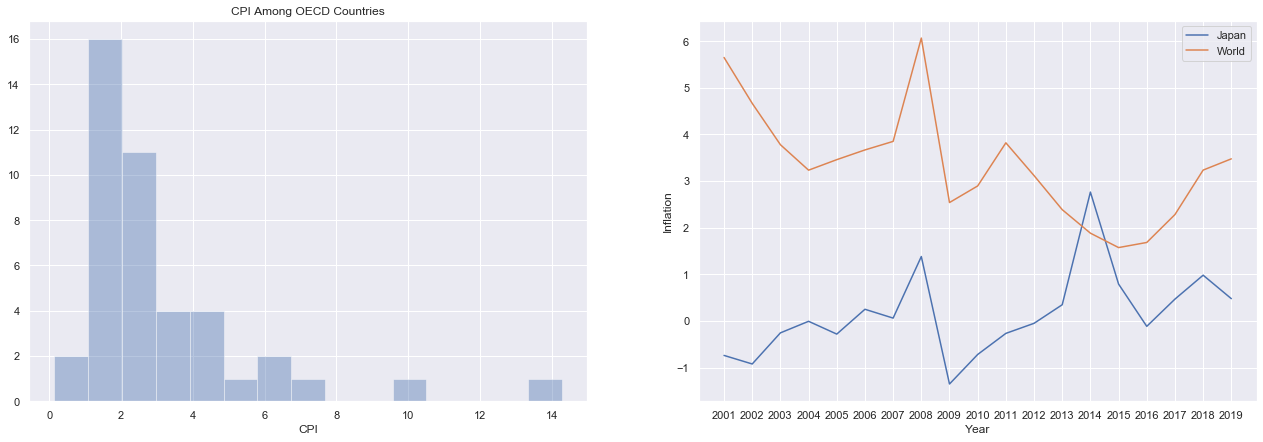

In [4]:
# import data
cpi_history = pd.read_csv('data/cpi.csv')
oecd_cpi = cpi_index['CPI: 01-12 - All items']

# select data
cpi_history = cpi_history.loc[cpi_history['Subject'] == 'CPI: 01-12 - All items'][['Country', 'Time', 'Value']]
cpi_japan = cpi_history.loc[cpi_history['Country'] == 'Japan']
cpi_world = cpi_history.loc[cpi_history['Country'] != 'Japan']

# create data
time_series = cpi_world['Time'].unique()
avg_cpi = []

for time in time_series:
    avg_cpi.append(cpi_world.loc[cpi_world['Time'] == time]['Value'].mean())
    
# plot graph
plt.figure(figsize = (22, 7))

plt.subplot(1, 2, 1)
sns.distplot(oecd_cpi.values, kde=False)
plt.xlabel('CPI')
plt.title('CPI Among OECD Countries')

plt.subplot(1, 2, 2)
plt.plot(cpi_japan['Time'], cpi_japan['Value'], label="Japan")
plt.plot(cpi_japan['Time'], avg_cpi, label="World")
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

The left graph above shows a histogram of the CPI values for all OECD countries, and the right graph shows a time series for Japan's CPI rate from 2001-2019 and the CPI rate for all other OECD countries in the same time span. The histogram shows that out of all OECD countries, only 11 countries were able to meet the target inflation rate of 2%-3% for the past 20 years. The time series plot provides a clear visualization of Japan's low inflations in the past 20 years compared to OECD countries. Japan has only reached the target inflation rate in 2014 when the Bank of Japan announced its monetary policy. However the inflation has gone back to around 0.5% in 2019, showing no signs of a possible inflation in the near future.

## Comparing Economic and Social Factors

To understand the possible reason behind Japan's long-standing deflation, we collect information on economic and social factors for countries that have had an inflation between 2% and 3% for the past 20 years. We first figure out the country and their inflation rate.

The economic and social factors we collected data on are the following:
- Economic Index
- GDP
- Health Expenditures
    - Current expenditure on health
- Population 
    - Population based on sex and age group
- Purchasing Power Parity
    - Compares different countries' currencies through by measuring a basket of goods which consists of various goods and products.
- Production

In [5]:
country_list = cpi_index.index
cpi = cpi_index['CPI: 01-12 - All items'].values
cpi_dict = list(zip(country_list, cpi))

cpi_good = []
for cpi in cpi_dict:
    if cpi[1] >= 2 and cpi[1] <= 3:
        cpi_good.append(cpi)
        
cpi_series = pd.DataFrame({'CPI': [cpi[1] for cpi in cpi_good]}, index=[cpi[0] for cpi in cpi_good])
cpi_series = cpi_series.sort_values(by=['CPI'], ascending=False)
cpi_series

,CPI
Slovenia,2.759940
Australia,2.544193
Lithuania,2.508400
Korea,2.426587
China (People's Republic of),2.326316
Czech Republic,2.156178
Poland,2.154386
United States,2.106992
New Zealand,2.103123
United Kingdom,2.057895


The data frame shows that 12 countries above have all had 2% ~ 3% inflation for the past 20 years.

We then collect data regarding economic index, GDP, health, population, purchasing power parity, and productivity for the 12 countries and Japan. We then use principal component analysis (PCA) to visualize the data by reducing the dimension to 2.

In [6]:
def get_inflation_countries(data):
    """
    Get all data from the countries that have met inflation goal.
    """
    relevant_data =  data.loc[
        (data.index == 'Slovenia') |
        (data.index == 'Australia') |
        (data.index == 'Lithuania')|
        (data.index == 'Korea') |
        (data.index == 'China (People\'s Republic of)') |
        (data.index == 'Czech Republic') |
        (data.index == 'Poland') |
        (data.index == 'United States') |
        (data.index == 'New Zealand') |
        (data.index == 'United Kingdom') |
        (data.index == 'Norway') |
        (data.index == 'Spain') |
        (data.index == 'Japan')
    ]
    
    return relevant_data.sort_index()

In [7]:
# get data from relevant country from all imported data
# drop all columns with NaN
ei_inflation = get_inflation_countries(economic_index.dropna(axis='columns'))
cpi_inflation = get_inflation_countries(cpi_index.dropna(axis='columns'))
gdp_production_inflation = get_inflation_countries(gdp_production_index.dropna(axis='columns'))
health_inflation = get_inflation_countries(health_index.dropna(axis='columns'))
population_inflation = get_inflation_countries(population_index.dropna(axis='columns'))
ppp_inflation = get_inflation_countries(ppp_index.dropna(axis='columns'))
productivity_inflation = get_inflation_countries(productivity_ulc_index.dropna(axis='columns'))

In [8]:
def create_standarized_dataset(data):
    """
    Substitute NaN value with mean and standarize the data. Return as pd.DataFrame
    """
    # create pipeline
    data_copy = data.copy()
    
    if len(data.columns) > 1:
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="mean")),
            ('std_scaler', StandardScaler())
        ])
        transformed_data = num_pipeline.fit_transform(data_copy)
    else:
        transformed_data = StandardScaler().fit_transform(data)
    
    data_copy[:] = transformed_data
    return data_copy

In [9]:
# exclude purchasing power parity, and health as only one column
ei_standarized = create_standarized_dataset(ei_inflation)
gdp_production_standarized = create_standarized_dataset(gdp_production_inflation)
population_standarized = create_standarized_dataset(population_inflation)
productivity_standarized = create_standarized_dataset(productivity_inflation)
health_standarized = create_standarized_dataset(health_inflation)
ppp_standarized = create_standarized_dataset(ppp_inflation)

In [10]:
# apply PCA transformation
pca = PCA(n_components=2)

ei_reduced = pca.fit_transform(ei_standarized)
gdp_production_reduced = pca.fit_transform(gdp_production_standarized)
population_reduced = pca.fit_transform(population_inflation)
productivity_reduced = pca.fit_transform(productivity_standarized)

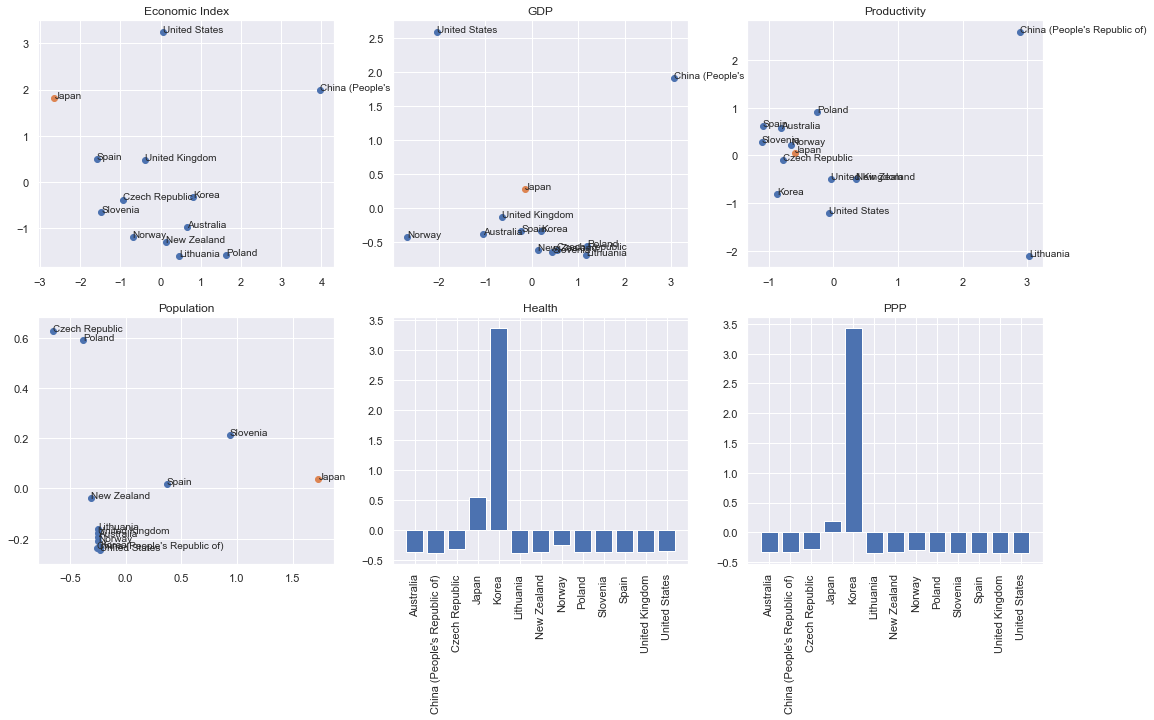

In [11]:
# plot data
plt.figure(figsize=(18, 10))

index = 1
reduced_data = [("Economic Index", ei_reduced), ("GDP", gdp_production_reduced), 
                ("Productivity", productivity_reduced), ("Population", population_reduced), ("Health", health_standarized),
               ("PPP", ppp_standarized)]

for title, data in reduced_data:
    plt.subplot(2, 3, index)
    
    if isinstance(data, pd.DataFrame):
        plt.title(title)
        plt.xticks(rotation=90)
        plt.bar([x for x in data.index], np.ndarray.flatten(data.values))
    else:
        japan = data[3]
        others = np.delete(data, 3, 0)

        plt.scatter(others[:, 0], others[:, 1])
        plt.scatter(japan[0], japan[1])

        country_data = [x for x in ei_inflation.index if x != 'Japan']
        for i, txt in enumerate(country_data):
            plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
        plt.annotate("Japan", (japan[0], japan[1]))
        plt.title(title)
    
    index += 1
plt.show()

From the 6 graphs we can deduce the following information:

- Economic Index
    - The scatter plot shows that Japan is located far away from China. Since China's economy is growing in a high rate, exploring the differences between Japan and China can provide possible insight.
- GDP
    - For GDP, USA and China are the two countries that are located further away from the rest of the country. Japan is the closest country to the two countries in terms of distance.
- Productivity
    - The productivity data suggests that Japan is mostly similar with the other OECD countries. 
- Population
    - The population scatter plot shows that Japan is located away from the majority of the countries. 
- Health
    - Japan's current expenditure on health is high compared to other countries. This may be the reason for Japanese people having a long life expectancy.
- Purchasing Power Parity
    - From the bar chart we can also see that Japan's purchasing power parity is higher than all countries except for Korea.

## Looking into Economic and Social Factors

In this section we look into important economic and social factors that can be used to understand the differences between Japan and the other countries. The factors includes ones that were used for PCA analysis, and new factors that can possibly provide new insights.

### Economic Index

In [12]:
ei_inflation

,"Exports in goods, s.a.","Imports in goods, s.a.",Share prices,Consumer prices: all items,"Gross domestic product; constant prices, s.a.",Overnight interbank rate,"Current account as a % of GDP, s.a."
,,,,,,,
Australia,65.066161,62.010703,4.435165,31.276290,2.846152,3.706842,-3.954578
China (People's Republic of),516.261858,435.157550,7.711203,30.965639,9.172153,3.067895,3.539535
Czech Republic,50.526682,46.654352,5.720108,32.023710,2.786704,1.544737,-1.939866
Japan,219.260484,214.209076,2.033844,32.824824,0.804440,0.070305,2.969035
Korea,144.481164,132.210814,6.875917,31.425293,3.853836,2.846316,3.056706
Lithuania,16.718985,16.775606,15.079314,31.495382,4.169892,1.373325,-3.171408
New Zealand,14.263578,15.094824,5.327814,31.740922,2.883612,3.924211,-3.701504
Norway,41.554862,27.571758,11.007439,32.040802,1.598191,2.647895,11.027120
Poland,60.829151,63.049286,8.414118,31.065411,3.791841,4.434211,-3.014520


The data frame above shows two indicators in which Japan has very different values from the rest of the countries:

- Gross domestic product (constant prices)
    - Real gross domestic product is a macroeconomic statistic that measures the value of the goods and services produced by an economy in a specific period, adjusted for inflation.
    - Japan shows little growth with an average of 0.8, while all the other countries growth higher than 1.5.
- Overnight interbank rate
    - The overnight rate is the interest rate at which a depository institution (generally banks) lends or borrows funds with another depository institution in the overnight market. In many countries, the overnight rate is the interest rate the central bank sets to target monetary policy.
    - Japan's overnight interbank rate is much smaller compared to the other countries which means that banks are more encourage to borrow from each other. This may be due to boost economic production to increase prices.

### Population

To get a better understanding of the population structure of each country, we import a new data that has the following information:

- Total Population
- Percentage of population over 65
- Percentage of population between 15 and 64
- Percentage of population under 15

In [13]:
# import data
population_data = pd.read_csv('data/population_total.csv')
population_data = population_data.drop(columns=['LOCATION', 'SEX', 'Sex', 'AGE', 'TIME', 'Flag Codes', 'Flags'])
population_data.head()

,Country,Age,Time,Value
0,Australia,Total,2001,19274701.0
1,Australia,Total,2002,19495210.0
2,Australia,Total,2003,19720737.0
3,Australia,Total,2004,19932722.0
4,Australia,Total,2005,20176844.0


In [14]:
total_population = population_data.loc[population_data['Age'] == 'Total']
over_65 = population_data.loc[population_data['Age'] == 'Share of 65 and over - elderly']
from_15_64 = population_data.loc[population_data['Age'] == 'Share of 15 to 64 - working age']
under_15 = population_data.loc[population_data['Age'] == 'Share of under 15 - children']

In [15]:
country_list_population = population_data['Country'].unique()

def get_dict_data(data, country_list):
    """
    """
    data_arr = []
    
    for country in country_list:
        data_country = data.loc[data['Country'] == country][['Time', 'Value']].values
        data_arr.append(data_country)
        
    colors = ['black', 'lightcoral', 'chocolate', 'darkorange', 'goldenrod', 'palegreen', 'lightseagreen',
             'darkslategray', 'deepskyblue', 'navy', 'blueviolet', 'magenta', 'crimson']
        
    list_zip = list(zip(country_list, data_arr, colors))
    return list_zip

In [16]:
population_countries = get_dict_data(total_population, country_list_population)
over_65_countries = get_dict_data(over_65, country_list_population)
from_15_64_countries = get_dict_data(from_15_64, country_list_population)
under_15_countries = get_dict_data(under_15, country_list_population)

In [17]:
def plot_line_graph(data):
    for datum in data:
        plt.plot(datum[1][:, 0], datum[1][:, 1], datum[2], label=datum[0])
    plt.xticks(range(2001, 2019, 5))
    plt.legend(prop={'size': 6})
    plt.xlabel('Year')

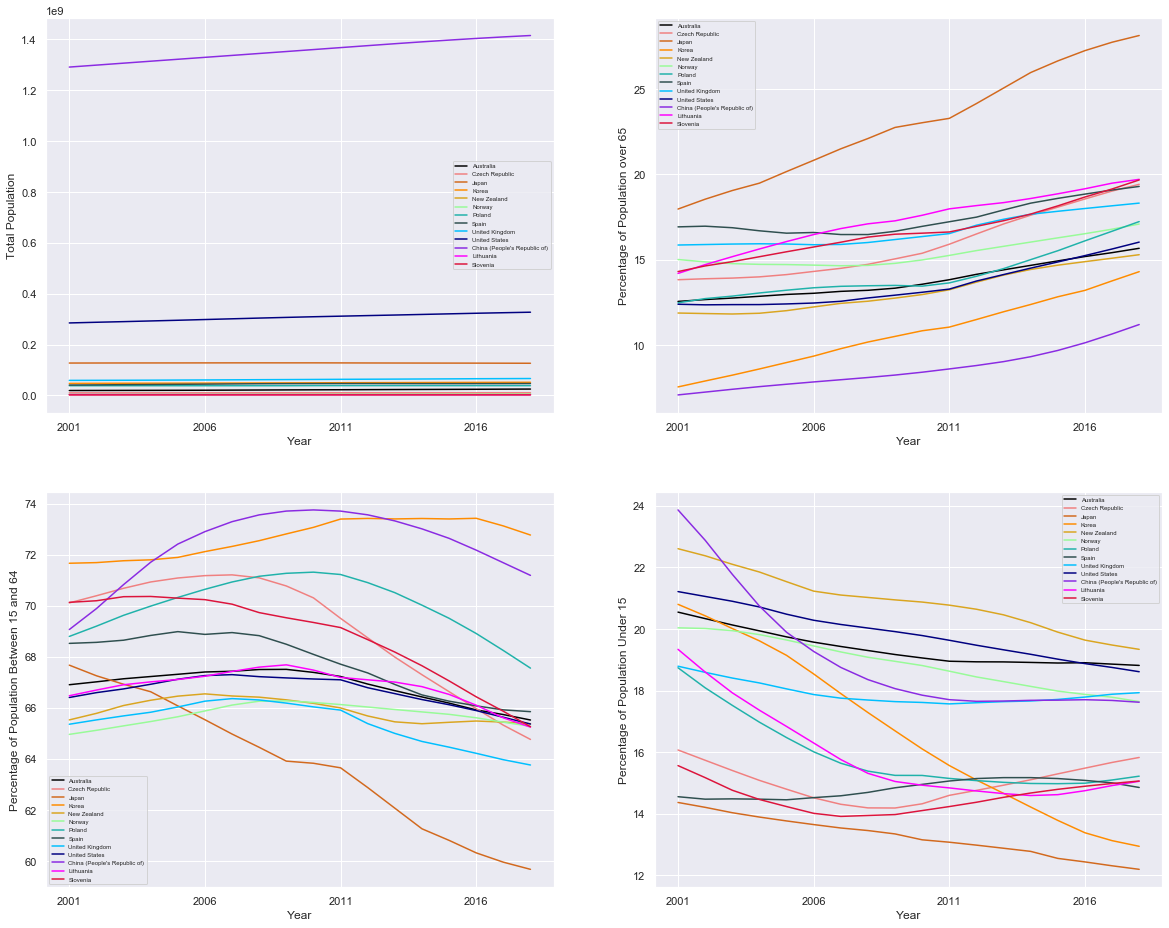

In [18]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plot_line_graph(population_countries)
plt.ylabel('Total Population')

plt.subplot(2, 2, 2)
plot_line_graph(over_65_countries)
plt.ylabel('Percentage of Population over 65')

plt.subplot(2, 2, 3)
plot_line_graph(from_15_64_countries)
plt.ylabel('Percentage of Population Between 15 and 64')

plt.subplot(2, 2, 4)
plot_line_graph(under_15_countries)
plt.ylabel('Percentage of Population Under 15')

plt.show()

From the top left line graph we can see that Japan's total population is in a downward trend; however, there seems to be no major decrease in the total population. Considering the decline in population we can see some troubling information from the three other graphs. The top right graph shows that the population over 65 is increasing each year with the percentage reaching close to 30%. On the other hand the bottom two graphs shows that the working population is decreasing and the amount of children are also decreasing as well. 

If such trend continues, Japan will have a population structure in which a small working population supports a large popualtion of elderly people who doesn't work. This can cause major issues in the future as the working population will be taxed more to support the pension fund. Therefore, the working population may spend less on goods and services that can prevent an inflationary trend.

### GDP

In [19]:
gdp_production_inflation

,Gross Domestic Product (GDP); millions,GDP per head of population,GDP per person employed
,,,
Australia,9.495379e+05,42361.716217,82876.488548
China (People's Republic of),1.367807e+07,10059.324015,17852.530240
Czech Republic,2.983312e+05,28508.055581,58144.373383
Japan,4.515240e+06,35448.689094,68223.444759
Korea,1.574108e+06,31532.284260,63686.265288
Lithuania,6.753784e+04,22315.196059,49887.903082
New Zealand,1.431837e+05,32243.940811,64090.023236
Norway,2.785042e+05,56242.856037,108003.587378
Poland,8.028952e+05,20920.863079,51960.398046


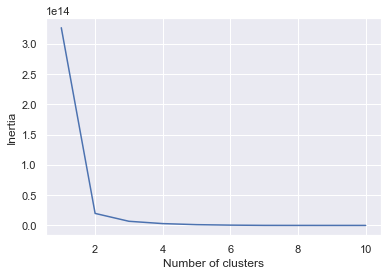

In [20]:
inertia_scores = []

for num in range(1, 11, 1):
    kmeans = KMeans(n_clusters=num)
    gdp_production_kmeans = kmeans.fit(gdp_production_inflation.values)
    inertia_scores.append(kmeans.inertia_)
    
plt.plot(list(range(1, 11, 1)), inertia_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

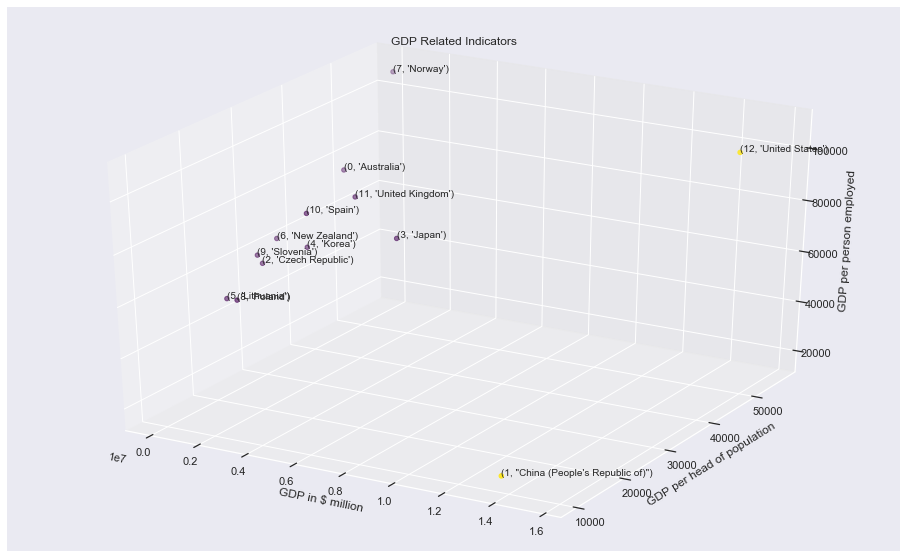

In [21]:
gdp_prod_kmeans = KMeans(n_clusters=2).fit_predict(gdp_production_inflation.values)
gdp = gdp_production_inflation['Gross Domestic Product (GDP); millions'].values
gdp_per_head = gdp_production_inflation['GDP per head of population'].values
gdp_per_employed = gdp_production_inflation['GDP per person employed'].values
country_data = list(zip(range(len(gdp_production_inflation)), gdp_production_inflation.index))

plt.figure(figsize=(16, 10))
ax = plt.axes(projection = '3d')
ax.scatter(gdp, gdp_per_head, gdp_per_employed, c=gdp_prod_kmeans , cmap='viridis')

for i, txt in enumerate(country_data):
    ax.text(gdp[i], gdp_per_head[i], gdp_per_employed[i], txt)
ax.set_title("GDP Related Indicators")
ax.set_xlabel("GDP in $ million")
ax.set_ylabel('GDP per head of population')
ax.set_zlabel('GDP per person employed')
plt.show()

The 3D scatter plot above shows that GDP is not a direct indicator for inflation as Japan is located near a cluster. If GDP is a direct indicator then Japan has have a higher inflation rate as Japan shows strong resemblance to most countries.

However, China provides an example that a country with a lower GDP per capita can maintain an inflation target of 2% ~ 3%. China's GDP per head of population and GDP per person employed is significantly lower than the other countries; while their GDP is higher than all countries except for the US. Such phenomenon shows that the population making more than the average income are spending enough on goods and services which keeps inflation at a stable rate.  

### Balance of Payments

Balance of payment is a statement of all transaction made between an organization is one country and the rest of the world over a period of time. The BOP statement consists of two accounts: the current account and the capital account. The current account includes transaction in goods, services, investment income, and current transfers. On the other hand the capital account keeps tracks of the net change in a nation's assets and liabilities during a year.

In [22]:
# import data and drop unnecessary columns
balance_payment = pd.read_csv('data/balance_payment.csv')
balance_payment = balance_payment[['Subject', 'Country', 'Time', 'Value']] # units all in million
balance_payment.head()

,Subject,Country,Time,Value
0,"Current account, balance",Korea,2001,2165.2
1,"Current account, balance",Korea,2002,4066.1
2,"Current account, balance",Korea,2003,11308.3
3,"Current account, balance",Korea,2004,29289.9
4,"Current account, balance",Korea,2005,12208.6


In [23]:
# seperate data frame by subject
current_account = balance_payment.loc[balance_payment['Subject'] == 'Current account, balance']
goods = balance_payment.loc[balance_payment['Subject'] == 'Goods, balance']
services = balance_payment.loc[balance_payment['Subject'] == 'Services, balance']
primary_income = balance_payment.loc[balance_payment['Subject'] == 'Primary income, balance']
secondary_income = balance_payment.loc[balance_payment['Subject'] == 'Secondary income, balance']
capital_account = balance_payment.loc[balance_payment['Subject'] == 'Capital account, balance']

In [24]:
country_list_bop = current_account['Country'].unique()

ca_by_country = get_dict_data(current_account, country_list_bop)
goods_by_country = get_dict_data(goods, country_list_bop)
services_by_country = get_dict_data(services, country_list_bop)
pi_by_country = get_dict_data(primary_income, country_list_bop)
si_by_country = get_dict_data(secondary_income, country_list_bop)
capital_by_country = get_dict_data(capital_account, country_list_bop)

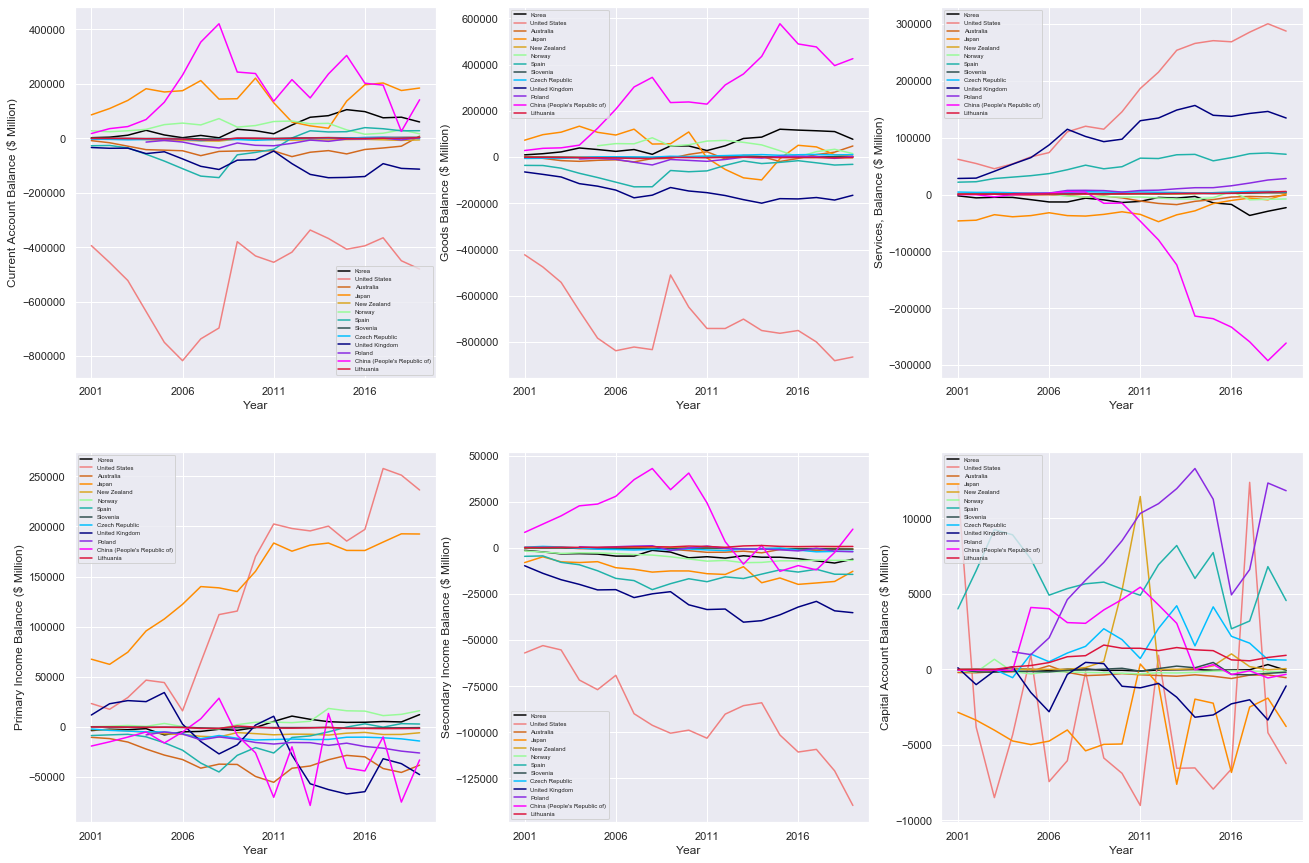

In [25]:
plt.figure(figsize=(22, 15))

plt.subplot(2, 3, 1)
plot_line_graph(ca_by_country)
plt.ylabel('Current Account Balance ($ Million)')
plt.xlabel('Year')

plt.subplot(2, 3, 2)
plot_line_graph(goods_by_country)
plt.ylabel('Goods Balance ($ Million)')
plt.xlabel('Year')

plt.subplot(2, 3, 3)
plot_line_graph(services_by_country)
plt.ylabel('Services, Balance ($ Million)')
plt.xlabel('Year')

plt.subplot(2, 3, 4)
plot_line_graph(pi_by_country)
plt.ylabel('Primary Income Balance ($ Million)')
plt.xlabel('Year')

plt.subplot(2, 3, 5)
plot_line_graph(si_by_country)
plt.ylabel('Secondary Income Balance ($ Million)')
plt.xlabel('Year')

plt.subplot(2, 3, 6)
plot_line_graph(capital_by_country)
plt.ylabel('Capital Account Balance ($ Million)')
plt.xlabel('Year')

plt.show()

The current account balance shows that Japan has been running on a surplus for the past 20 years which means that Japan has been exporting more goods and services than importing them. When we take a closer look into goods and services, Japan is on a surplus with goods but is on a deficit with services.

Before we look into primary and secondary income balance, we define the terms (source):
- Primary income is the income that resident earn from the rest of the world from working and from financial investments
- Secondary income consists of two parts
    - The income that residents earn from the rest of the world from the government
    - Transaction between residents and the rest of the world where one part provides something to be consumer by another party without receiving anything in return
    
The primary income balance shows that Japan has a surplus meaning that Japanese residents earns more from the rest of the world than they lose. On ther other hand, Japan has a secondary income deficit. The deficit represents that Japanese citizens are losing income to the world or are giving more goods and services to other countries.

From the bottom right graph Japan is on a capital account deficit for the past 20 years. The deficit meamss money is flowing out of the country and suggests the Japan is increasing ownership of foreign assets.

### Unemployment Rate

In [26]:
unemployment_interest_data = pd.read_csv('data/unemployment_&_interest_rate.csv')
unemployment_data = unemployment_interest_data.loc[unemployment_interest_data['Variable'] == 'Unemployment rate']
unemployment_data = unemployment_data[['Country', 'Variable', 'Time', 'Value']]

In [27]:
country_data = unemployment_data['Country'].unique()
unemployment_time_series = get_dict_data(unemployment_data, country_data)

china_unemployment = ('China', np.array([
    [2001., 3.80], [2002., 4.24], [2003., 4.58], [2004., 4.49], [2005., 4.52], [2006., 4.43], [2007., 4.35],
    [2008., 4.59], [2009., 4.72], [2010., 4.53], [2011., 4.55], [2012., 4.57], [2013., 4.59], [2014., 4.61],
    [2015., 4.63], [2016., 4.54], [2017., 4.44], [2018., 4.28], [2019., 4.32]
]), 'crimson')

unemployment_time_series.append(china_unemployment)

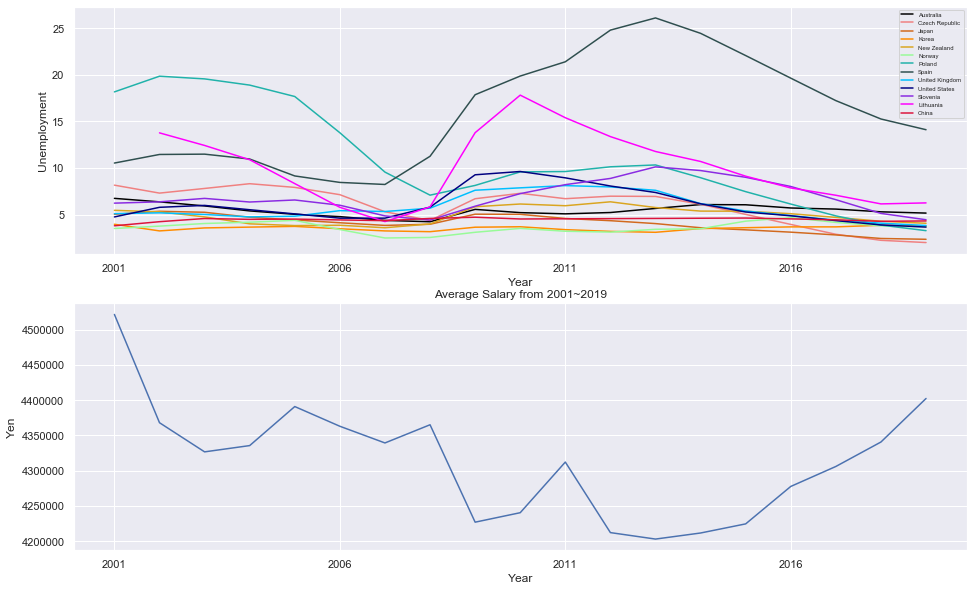

In [37]:
japan_salary = pd.read_csv('data/japan_salary.csv')
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
plot_line_graph(unemployment_time_series)
plt.xlabel('Year')
plt.ylabel('Unemployment')

plt.subplot(2, 1, 2)
plt.plot(japan_salary['Time'].values, japan_salary['Value'].values)
plt.xticks(range(2001, 2019, 5))
plt.xlabel('Year')
plt.ylabel('Yen')
plt.title('Average Salary from 2001~2019')

plt.show()

The line graph on the top shows the unemployment time series graph. From the graph we can see that Japan has a very low unemployment rate for the past 20 years with unemployment rate around 4%. The line graph on the bottom show's Japan's average annual salary from 2001-2019 which has been fluctuating a lot. The peak was in 2001 and from there the average salary has been decreasing. From 2013, the salary has been increasing steadly. 

From the Phillips curve, inflation in wage and unemployment is inveresly proportional. Therefore to increase inflation Japan can try to reduce its unemployment rate which may be hard because the rate is very low.

### Interest Rates

#### Short Term Interest Rate

In [29]:
short_interest = unemployment_interest_data.loc[unemployment_interest_data['Variable'] == 'Short-term interest rate']
short_interest = short_interest[['Country', 'Variable', 'Time', 'Value']]
country_data = short_interest['Country'].unique()

short_interest_time_series = get_dict_data(short_interest, country_data)

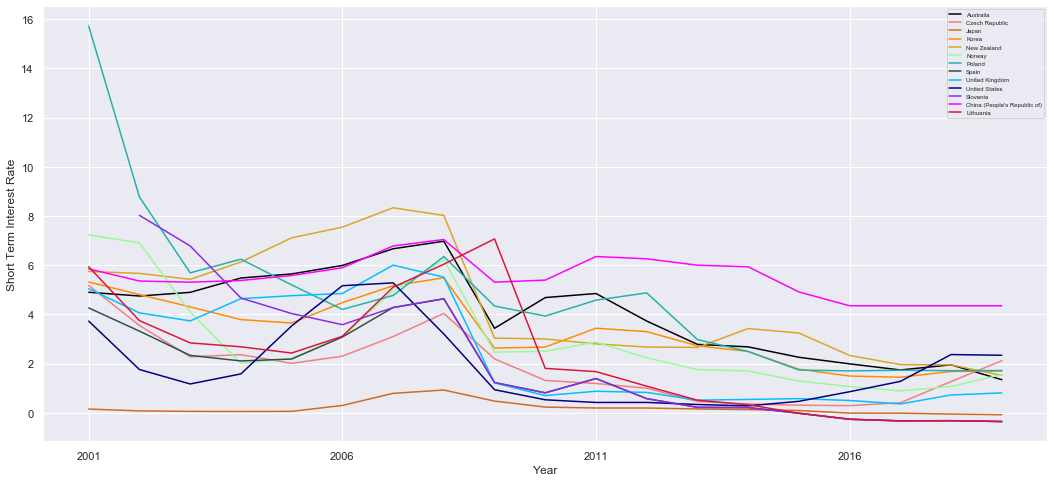

In [30]:
plt.figure(figsize=(18, 8))
plot_line_graph(short_interest_time_series)
plt.ylabel('Short Term Interest Rate')
plt.xlabel('Year')
plt.show()

The short term interest rate are the rates at which short-term borrowings are effected between financial institutions or the rate at which short-term government paper is issued or traded in the market. Japan's low short-term interest rate represents Japan's effort to make people borrow money to make large purchases to boost the economy. However, seeing that Japan's interest rate has consistenly below 1%, we can see that Japan's effort to encourage purchases are not paying off.

#### Long Term Interest Rate

In [31]:
long_interest = unemployment_interest_data.loc[unemployment_interest_data['Variable'] == 
                                               'Long-term interest rate on government bonds']
long_interest = long_interest[['Country', 'Variable', 'Time', 'Value']]

long_interest_time_series = get_dict_data(long_interest, country_data)

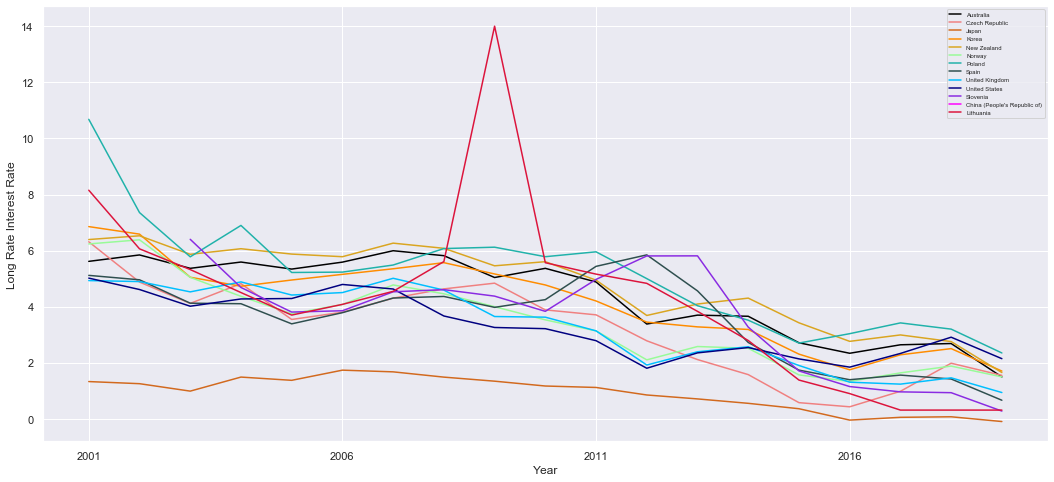

In [32]:
plt.figure(figsize=(18, 8))
plot_line_graph(long_interest_time_series)
plt.ylabel('Long Rate Interest Rate')
plt.xlabel('Year')
plt.show()

Long-term interest rate (LTIR) refers to government bonds that mature in 10 years and tends to reflect investor's speculation on the country's future econonmic wellbeing. Looking at Japan's long-term interest rate, we can see that Japan's LTIR was the highest in 2006 with close to 2%; from 2006 the value has been decreasing and is currently near 0%. Although such trend may simply reflect the anxiety for Japan's economic wellbeing, from 2013 the Bank of Japan has introduced an aggresive quantitative and qualitative monetary easing which has caused the LTIR to decrease as well. 

## Why Can't Japan get out of a Deflation?

## Sources

Introduction
- https://www.investopedia.com/articles/economics/08/japan-1990s-credit-crunch-liquidity-trap.asp#:~:text=From%201991%20through%202001%2C%20Japan,pace%20than%20other%20industrialized%20nations.
- https://www.japantimes.co.jp/opinion/2017/03/29/commentary/japan-commentary/the-truth-about-deflation/#.XwAQ15MzaHE
- https://www.sr-sv.com/japans-quantitative-and-qualitative-easing/#:~:text=On%20April%204%20Bank%20of,after%2015%20years%20of%20deflation.
- https://www.investopedia.com/terms/d/deflation.asp


Balance of Payment
- https://www.investopedia.com/terms/b/bop.asp
- https://www.rba.gov.au/education/resources/explainers/the-balance-of-payments.html